In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
# Batheymetry averaged about the core
h = np.transpose(dataset.variables['h'], axes=(1, 0))
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    fixed_field=h,
    colname="h"
)
# df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

# Coriolis
f = np.transpose(dataset.variables['f'], axes=(1, 0))
df_eddies['f'] = f[df_eddies.ic, df_eddies.jc]

# Slope Magnitude
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho)
s = np.hypot(dhdx, dhdy)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# topographic gradient
dh_dN = - (np.sin(angle) * dhdx + np.cos(angle) * dhdy)
dh_dE = - (np.cos(angle) * dhdx - np.sin(angle) * dhdy)

# planetary gradient
f = np.transpose(dataset.variables['f'], axes=(1, 0))
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)
df_dE = - (np.cos(angle) * dfdx - np.sin(angle) * dfdy)

# beta
df_eddies['beta'] = df_dN[df_eddies.ic, df_eddies.jc]
beta = df_dN

# planetary beta
df_eddies['plan_beta'] = df_dN[df_eddies.ic, df_eddies.jc] / df_eddies.h.values
plan_beta = df_dN / h

# topographic beta
df_eddies['topo_beta'] = - df_eddies.f / df_eddies.h**2 * dh_dN[df_eddies.ic, df_eddies.jc]
topo_beta = -f / h**2 * dh_dN


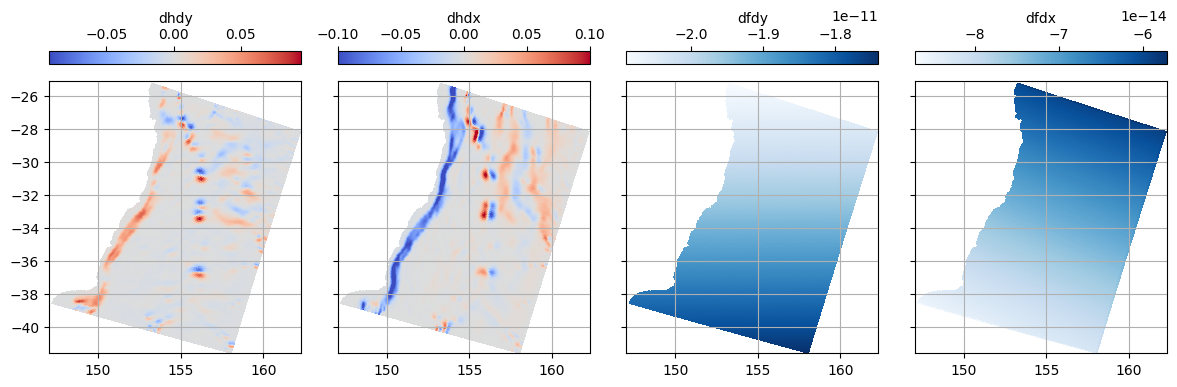

In [4]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
c = axs[0].pcolor(lon_rho, lat_rho, dh_dN, cmap='coolwarm')
plt.colorbar(c, ax=axs[0], location='top', label='dhdy')
c = axs[1].pcolor(lon_rho, lat_rho, dh_dE, cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar(c, ax=axs[1], location='top', label='dhdx')

c = axs[2].pcolor(lon_rho, lat_rho, df_dN, cmap='Blues')
plt.colorbar(c, ax=axs[2], location='top', label='dfdy')
c = axs[3].pcolor(lon_rho, lat_rho, df_dE, cmap='Blues')
plt.colorbar(c, ax=axs[3], location='top', label='dfdx')
for ax in axs:
    ax.axis('equal'); ax.grid('on')
plt.tight_layout()


### $\beta$ effect

#### Planetary Beta
$\beta_t=\frac{1}{H}f_y$


#### Topographic Beta
$\beta_t=-\frac{f}{H}h_y$


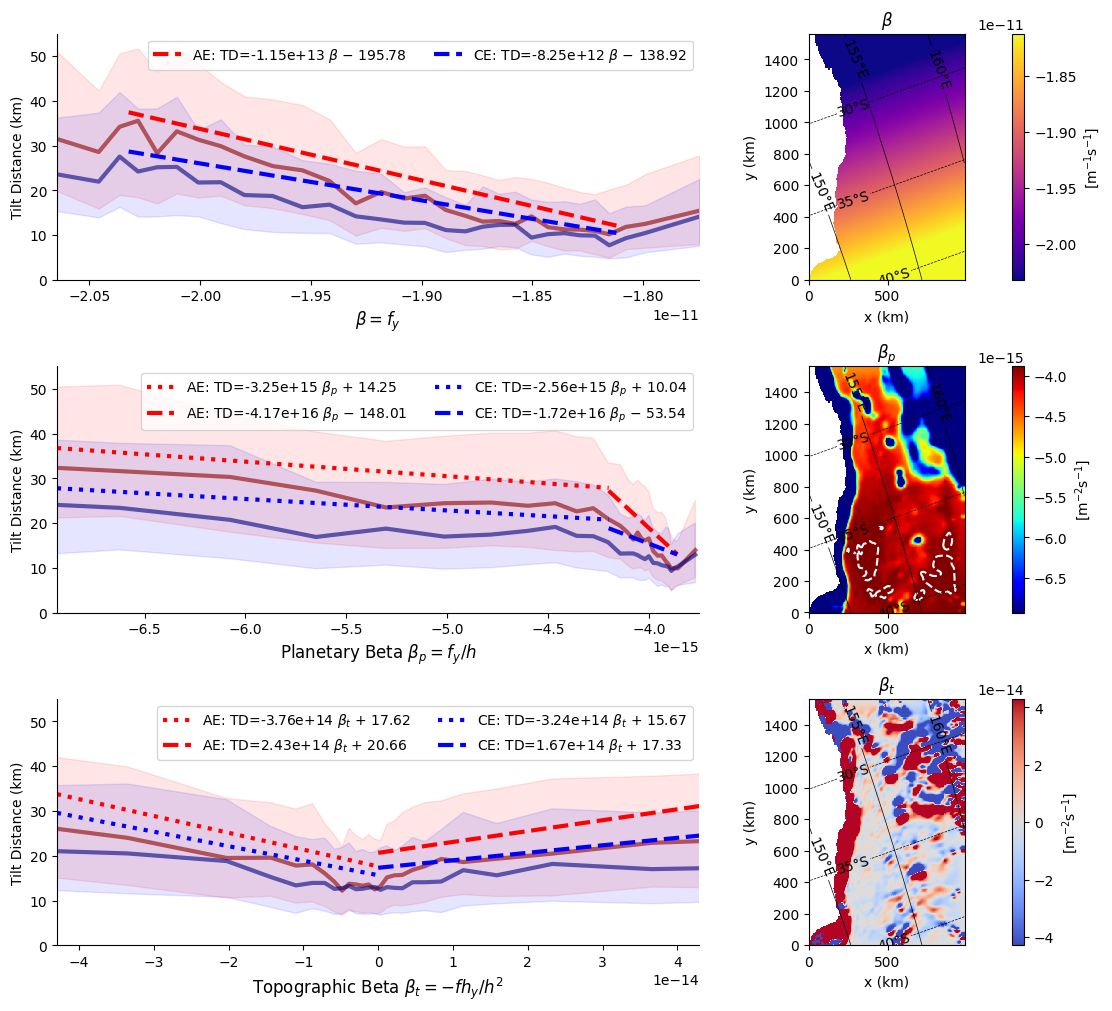

In [5]:
fig = plt.figure(figsize=(11, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[2.5, 1.0], hspace=0, wspace=0)

axs_L = [fig.add_subplot(gs[i, 0]) for i in range(3)]
axs_R = [fig.add_subplot(gs[i, 1]) for i in range(3)]

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None, reg_hi_override=None, scatter=False, xlim_flag=False):
    df_all = df_eddies.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        dfm = df_eddies[df_eddies.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        xval = dfm[xcol].values
        tilt = dfm['TiltDis'].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10)

        if split is None:
            lo, hi = np.nanpercentile(df_eddies[xcol], [10, 90])
            mask = (xval >= lo) & (xval <= hi)
            m, c, *_ = linregress(xval[mask], tilt[mask])
            xf = np.linspace(lo, hi, 200)
            ax.plot(
                xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}'
            )
        else:
            lo, hi = np.nanpercentile(df_eddies[xcol], [10, 90])
            hi2 = reg_hi_override if reg_hi_override is not None else hi

            for l, (a, b) in enumerate(zip([lo, split], [split, hi2])):
                mask = (xval >= a) & (xval <= b)
                if mask.sum() > 2:
                    m, c, *_ = linregress(xval[mask], tilt[mask])
                    xf = np.linspace(a, b, 200)
                    ax.plot(
                        xf, m*xf + c,
                        ':' if l == 0 else '--',
                        lw=3,
                        color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}'
                    )

    ax.set_ylim(0, 55)
    if xlim is None:
        ax.set_xlim(*np.nanpercentile(df_eddies[xcol], [10, 90]))
    else:
        ax.set_xlim(*xlim)

    if xlim_flag:
        ax.set_xlim(bin_centers.min(), bin_centers.max())

    ax.legend(loc='upper right', ncol=2)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# =========================
# LEFT COLUMN — TD PANELS
# =========================
panel(
    axs_L[0],
    'beta',
    r'$\beta=f_y$',
    r'$\beta$',
    xlim_flag=True,
    scatter=False
)
axs_L[0].set_ylabel('Tilt Distance (km)')

panel(
    axs_L[1],
    'plan_beta',
    r'Planetary Beta $\beta_p=f_y/h$',
    r'$\beta_p$',
    split=-4.2e-15,
    reg_hi_override=-3.86e-15,
    xlim=(np.nanpercentile(df_eddies.plan_beta, [10, 90])[0], -3.75e-15)
)
axs_L[1].set_ylabel('Tilt Distance (km)')

lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
cent = min(abs(lo), abs(hi))
panel(
    axs_L[2],
    'topo_beta',
    r'Topographic Beta $\beta_t=-fh_y/h^2$',
    r'$\beta_t$',
    split=0.0,
    xlim=(-cent, cent)
)

axs_L[2].set_ylabel('Tilt Distance (km)')


# =========================
# RIGHT COLUMN — MAPS
# =========================
lo, hi = np.nanpercentile(df_eddies.beta, [10, 90])
pc = axs_R[0].pcolor(X_grid, Y_grid, beta, cmap='plasma', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs_R[0], label=r'[m$^{-1}$s$^{-1}$]')
axs_R[0].set_title(r'$\beta$')

lo, hi = np.nanpercentile(df_eddies.plan_beta, [10, 90])
pc = axs_R[1].pcolor(X_grid, Y_grid, plan_beta, cmap='jet', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs_R[1], label=r'[m$^{-2}$s$^{-1}$]')
axs_R[1].set_title(r'$\beta_p$')
axs_R[1].contour(X_grid, Y_grid, plan_beta, levels=[-3.86e-15], colors='w')

lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
cent = min(abs(lo), abs(hi))
pc = axs_R[2].pcolor(
    X_grid, Y_grid, topo_beta,
    cmap='coolwarm', vmin=-cent, vmax=cent
)
fig.colorbar(pc, ax=axs_R[2], label=r'[m$^{-2}$s$^{-1}$]')
axs_R[2].set_title(r'$\beta_t$')

for ax in axs_R:
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)');

plt.show()


In [6]:
rnge = df_eddies.beta.max() - df_eddies.beta.min()
print('change in TD over beta domain')
print(f'AE: {9.1e12 * rnge:.1f}, CE: {7.22e12 * rnge:.1f}')


change in TD over beta domain
AE: 29.4, CE: 23.3


### Bottom Slope

In [7]:
h = np.transpose(dataset.variables['h'], axes=(1, 0))


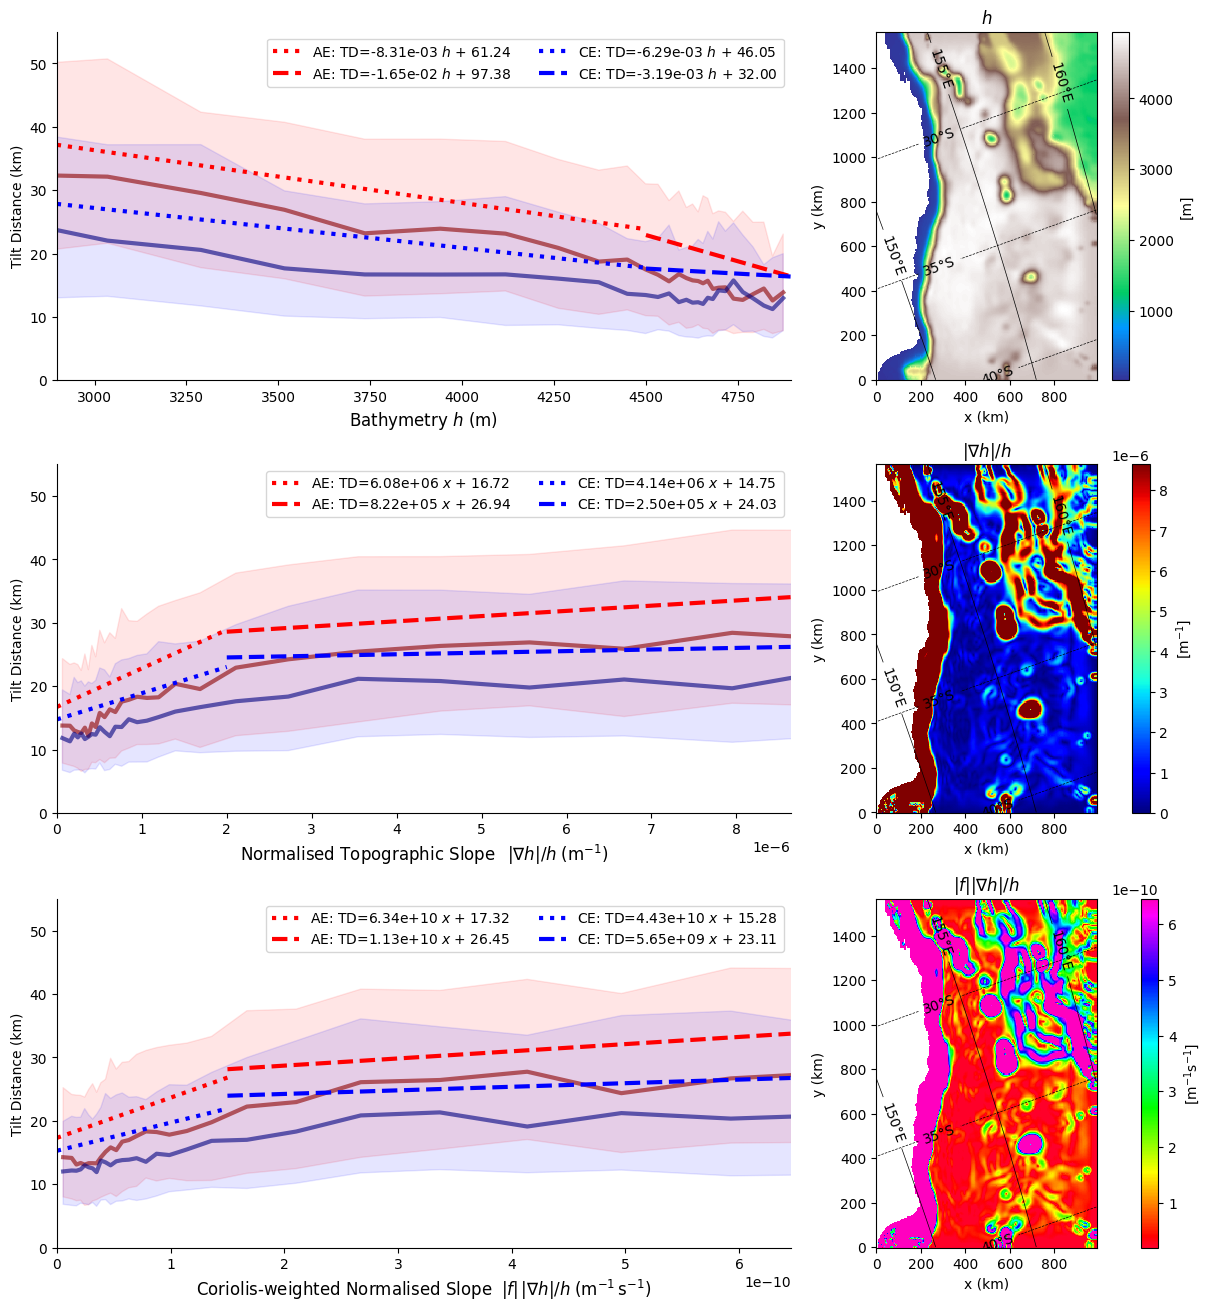

In [8]:
df_eddies['s_norm']   = df_eddies.s / df_eddies.h
df_eddies['s_norm_f'] = df_eddies.f.abs() * df_eddies.s / df_eddies.h

fig = plt.figure(figsize=(12, 13), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[2.5, 1.0], hspace=0.0, wspace=0.0)

axs_L = [fig.add_subplot(gs[i, 0]) for i in range(3)]
axs_R = [fig.add_subplot(gs[i, 1]) for i in range(3)]

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None,
          reg_hi_override=None, reg_lo_override=None, scatter=False):
    df_all = df_eddies.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        dfm = df_eddies[df_eddies.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        xval = dfm[xcol].values
        tilt = dfm['TiltDis'].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10)

        if split is None:
            m, c, *_ = linregress(xval, tilt)
            xf = np.linspace(xval.min(), xval.max(), 200)
            ax.plot(xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                    label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}')
        else:
            lo, hi = np.nanpercentile(df_eddies[xcol], [10, 90])
            hi2 = reg_hi_override if reg_hi_override is not None else hi
            lo2 = reg_lo_override if reg_lo_override is not None else lo
            for l, (a, b) in enumerate(zip([lo2, split], [split, hi2])):
                msk = (xval >= a) & (xval <= b)
                if msk.sum() > 2:
                    m, c, *_ = linregress(xval[msk], tilt[msk])
                    xf = np.linspace(a, b, 200)
                    ax.plot(xf, m*xf + c, ':' if l == 0 else '--', lw=3, color=styles[cyc]['fill'],
                            label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}')

    ax.set_ylim(0, 55)
    ax.set_xlim(*(np.nanpercentile(df_eddies[xcol], [10, 90]) if xlim is None else xlim))
    ax.legend(loc='upper right', ncol=2)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Tilt Distance (km)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# =========================
# LEFT COLUMN — TD PANELS
# =========================
lo, hi = np.nanpercentile(df_eddies.h, [10, 90])
hi = df_eddies.h.max()
panel(
    axs_L[0],
    'h',
    r'Bathymetry $h$ (m)',
    '$h$',
    split=4500,
    xlim=(lo, hi),
    scatter=False,
    reg_hi_override=hi
)

lo, hi = np.nanpercentile(df_eddies.s_norm, [10, 90])
panel(
    axs_L[1],
    's_norm',
    r'Normalised Topographic Slope $\; \,|\nabla h|/h \; (\mathrm{m^{-1}})$',
    '$x$',
    split=2e-6,
    xlim=(0, hi),
    scatter=False,
    reg_lo_override=0
)

lo, hi = np.nanpercentile(df_eddies.s_norm_f, [10, 90])
panel(
    axs_L[2],
    's_norm_f',
    r'Coriolis-weighted Normalised Slope $\; |f|\,|\nabla h|/h \; (\mathrm{m^{-1}\,s^{-1}})$',
    '$x$',
    split=1.5e-10,
    xlim=(0, hi),
    scatter=False,
    reg_lo_override=0
)

# =========================
# RIGHT COLUMN — MAPS
# =========================
pc = axs_R[0].pcolor(X_grid, Y_grid, np.where(mask_rho, h, np.nan), cmap='terrain')
fig.colorbar(pc, ax=axs_R[0], label='[m]')
# axs_R[0].contour(X_grid, Y_grid, h, levels=[4500])
axs_R[0].set_title(r'$h$')

s_norm = s / h
lo, hi = np.nanpercentile(df_eddies.s_norm, [10, 90])
pc = axs_R[1].pcolor(X_grid, Y_grid, s_norm, vmin=0, vmax=hi, cmap='jet')
fig.colorbar(pc, ax=axs_R[1], label=r'[m$^{-1}$]')
axs_R[1].set_title(r'$|\nabla h|/h$')

s_norm_f = abs(f) * s / h
lo, hi = np.nanpercentile(df_eddies.s_norm_f, [10, 90])
pc = axs_R[2].pcolor(X_grid, Y_grid, s_norm_f, vmin=lo, vmax=hi, cmap='gist_rainbow')
fig.colorbar(pc, ax=axs_R[2], label=r'[m$^{-1}$s$^{-1}$]')
axs_R[2].set_title(r'$|f||\nabla h|/h$')

for ax in axs_R:
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')

plt.show()

